# Dados e Cálculo de Médias

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.manual_data import manual_data_path

In [2]:
#Carregar Dados
onibus_diesel_dia30= pd.read_csv(manual_data_path('calculo-emissao-poluentes-diario_2025-12-30_silver.csv'))
onibus_diesel_dia31= pd.read_csv(manual_data_path('calculo-emissao-poluentes-diario_2025-12-31_silver.csv'))
onibus_diesel_dia01= pd.read_csv(manual_data_path('calculo-emissao-poluentes-diario_2026-01-01_silver.csv'))

In [3]:
# Médias
list_dados = [
    (onibus_diesel_dia30, 30),
    (onibus_diesel_dia31, 31),
    (onibus_diesel_dia01, 1)
]

df_dados_dia = pd.DataFrame(
    columns=['dia', 'n_frota', 'total_co2_t', 'co2_media', 'mp_media', 'nox_media',]
)

for df, dia in list_dados:
    n_frota= df['codigo_onibus'].nunique() #len(unique)
    total_co2=df['emissao_co2'].sum() /1000 #toneladas
    co2_media=df['emissao_co2'].mean()
    mp_media= df['emissao_mp'].mean()
    nox_media = df['emissao_nox'].mean()

    
    df_dados_dia.loc[len(df_dados_dia)] = [
        dia,
        n_frota,
        total_co2,
        co2_media,
        mp_media,
        nox_media
    ]

todos_frota_media = df_dados_dia['n_frota'].mean().astype(int)
todos_co2_media= df_dados_dia['co2_media'].mean() 
todos_mp_media= df_dados_dia['mp_media'].mean()
todos_nox_media= df_dados_dia['nox_media'].mean()
print(
    f'''
    CO2: {round(todos_co2_media, 3)} Kg
    MP: {round(todos_mp_media, 3)} g
    NOx: {round(todos_nox_media, 3)} g
    Frota média: {todos_frota_media}
    '''
)
print(df_dados_dia)


    CO2: 257.627 Kg
    MP: 1.052 g
    NOx: 2.365 g
    Frota média: 8407
    
    dia  n_frota  total_co2_t   co2_media  mp_media  nox_media
0  30.0  10947.0  2555.809543  233.471229  0.980509   2.167026
1  31.0   7842.0  2020.250065  257.619238  1.057921   2.313529
2   1.0   6434.0  1813.038569  281.790266  1.116227   2.615777


# Simulação de Monte Carlo
Avalia cenários de emissão de CO2 com diferentes quantidades de ônibus a diesel em operação. Para os demais poluentes, será o mesmo processo.

In [4]:
def sim_monte_carlo(df_diesel, 
                    Y_qtdd_diesel, #ônibus a diesel
                    N=2000, 
                    dias=365):
    
    resultados_diarios = []

    for _ in range(N):
        amostra = df_diesel.sample(n=Y_qtdd_diesel, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados_diarios.append(emissao_total)

    resultados_diarios = np.array(resultados_diarios)
    resultados_acumulados = resultados_diarios * dias

    impacto_medio = resultados_diarios.mean()
    impacto_maximo = (
        df_diesel
        .nlargest(Y_qtdd_diesel, "emissao_co2")
        ["emissao_co2"]
        .sum()
    )
    impacto_diferenca = impacto_maximo - impacto_medio

    #intervalos de confiança
    IC_inf = np.percentile(resultados_diarios, 2.5)
    IC_sup = np.percentile(resultados_diarios, 97.5)

    return {
        "Y_onibus_diesel": Y_qtdd_diesel,
        "dias": dias,
        "impacto_medio_dia": impacto_medio,
        "IC_inf_dia": IC_inf,
        "IC_sup_dia": IC_sup,
        "impacto_maximo_dia": impacto_maximo,
        "impacto_diferenca_dia": impacto_diferenca,
        "impacto_medio_acumulado": resultados_acumulados.mean(),
        "IC_inf_acumulado": np.percentile(resultados_acumulados, 2.5),
        "IC_sup_acumulado": np.percentile(resultados_acumulados, 97.5),
        "total_emissao_dia": resultados_diarios,
        "total_emissao_acumulados": resultados_acumulados
    }

In [5]:
def estimar_frota_para_meta(
    df_diesel,
    meta_emissao,
    N=2000, #número de simulações
    Y_min=10, #qtd minima de onibus substituidos por elétricos
    Y_max=500, #qtdd máxima de onibus substituidos por elétricos
    passo=100
):

    resultados_meta = []

    for Y in range(Y_min, Y_max + 1, passo):
        sim = sim_monte_carlo(df_diesel, Y, N=N)

        valor = sim["impacto_medio_dia"]

        resultados_meta.append({
            "substituicoes_eletricos": Y,
            "impacto_estimado_medio": valor
        })

        if valor >= meta_emissao:
            break

    return pd.DataFrame(resultados_meta)

In [6]:
meta = 1000  #kg ou 1t de CO2 por dia

df_meta = estimar_frota_para_meta(
    onibus_diesel_dia31,
    meta_emissao=meta
)

display(df_meta.tail())

,substituicoes_eletricos,impacto_estimado_medio
0,10,2533.603283


In [7]:
tamanhos_frota = [50, 100, 200]
dias_projecao = 365

res = [
    sim_monte_carlo(onibus_diesel_dia31, y, dias=dias_projecao)
    for y in tamanhos_frota
]

In [8]:
tabela_resumo = pd.DataFrame([
    {
        "Ônibus  a serem substituídos": r["Y_onibus_diesel"],
        "Emissão média evitada (t CO2/dia)": r["impacto_medio_dia"]/1000,
        "IC95% inf (dia)": r["IC_inf_dia"],
        "IC95% sup (dia)": r["IC_sup_dia"],
        "Cenário máximo (t CO2/dia)": r["impacto_maximo_dia"]/1000,
        "Emissão média acumulada (t CO2)": r["impacto_medio_acumulado"]/1000
    }
    for r in res
]).round(4)

display(tabela_resumo)

,Ônibus a serem substituídos,Emissão média evitada (t CO2/dia),IC95% inf (dia),IC95% sup (dia),Cenário máximo (t CO2/dia),Emissão média acumulada (t CO2)
0,50,12.9225,9668.2754,16550.3388,78.6430,4716.7176
1,100,25.7399,21240.9876,31088.8712,128.1478,9395.0780
2,200,51.7030,45082.7838,62797.9558,212.8397,18871.5861


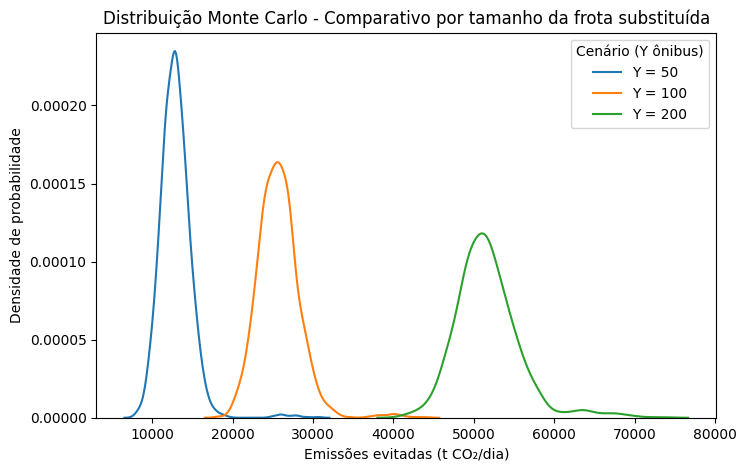

In [9]:
plt.figure(figsize=(8,5))
for r in res:
    sns.kdeplot(
        r["total_emissao_dia"],
        label=f"Y = {r['Y_onibus_diesel']}"
    )

plt.xlabel("Emissões evitadas (t CO₂/dia)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.show()